In [1]:
#Import thư viện :
import os
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import tifffile as tiff
import sklearn
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.optimizers import Adam
from keras.utils import normalize , img_to_array
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization
from keras.layers import Activation, Concatenate , UpSampling2D
import tensorflow as tf
from tensorflow.keras import backend as K

2024-03-22 04:09:50.732193: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-22 04:09:50.732359: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-22 04:09:50.891589: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 1. Xây dựng mạng Unet++

Mạng Unet ++ cần các yếu tố sau :
- Lớp tích chập (Convolution)
- Lớp Encoder
- Lớp Decoder

In [2]:
#Xây dựng các lớp cần thiết :
def Convolution(input, num_filters, bl_name):
  x = Conv2D(num_filters, 3, padding='same',name = 'Conv1_' + bl_name)(input)
  x = BatchNormalization(name='Norm1_'+bl_name)(x)
  x = Activation('relu', name='Act1_'+bl_name)(x)

  x = Conv2D(num_filters, 3,padding='same',name='Conv2_'+bl_name)(x)
  x = BatchNormalization(name='Norm2_'+bl_name)(x)
  x = Activation('relu', name='Act2_'+bl_name)(x)

  return x


def Encoder(input, num_filters, block_name):
  s = Convolution(input, num_filters, block_name)
  p = MaxPooling2D((2,2),name='MaxPooling_'+block_name)(s)

  return s, p


def Decoder(input, x_up , num_filters, block_name):
  #Add UpSampling2D to list Input :
  input.append(UpSampling2D()(x_up))

  #Concatenate :
  concat = concatenate(input)
  d = Convolution(concat , num_filters , bl_name = block_name)

  return d

In [3]:
#Xây dựng mạng neuron tích chập Unet++ :
# src : https://www.geeksforgeeks.org/unet-architecture-explained/?ref=ml_lbp
def Unet_plus_plus(input_shape=(256, 256, 3), num_classes=1, base_filter=32, deep_supervision=False) :
  inputs = Input(shape=input_shape)

  bf = base_filter 
  filters = [bf, bf*2, bf*4, bf*8, bf*16]

  #Encoding Path :
  x_00 , Pooling_00 = Encoder(inputs, filters[0], 'Encoder_00')
  x_10 , Pooling_10 = Encoder(Pooling_00, filters[1], 'Encoder01')
  x_20 , Pooling_20 = Encoder(Pooling_10, filters[2], 'Encoder02')
  x_30 , Pooling_30 = Encoder(Pooling_20, filters[3], 'Encoder03')
  x_40 , Pooling_40 = Encoder(Pooling_30, filters[4], 'Encoder04')

  #Nested Decoding Path :
  x_01 = Decoder(input = [x_00] , x_up = x_10 , num_filters = filters[0], block_name = 'Decoder01')
  x_11 = Decoder(input = [x_10] , x_up = x_20 , num_filters = filters[1], block_name = 'Decoder11')
  x_21 = Decoder(input = [x_20] , x_up = x_30 , num_filters = filters[2], block_name = 'Decoder21')
  x_31 = Decoder(input = [x_30] , x_up = x_40 , num_filters = filters[3], block_name = 'Decoder31')


  x_02 = Decoder(input = [x_00 , x_01] , x_up = x_11 , num_filters = filters[0],  block_name = 'Decoder02')
  x_12 = Decoder(input = [x_10 , x_11] , x_up = x_21 , num_filters = filters[1],  block_name = 'Decoder12')
  x_22 = Decoder(input = [x_20 , x_21] , x_up = x_31 , num_filters = filters[2],  block_name = 'Decoder22')


  x_03 = Decoder(input = [x_00 , x_01 , x_02] , x_up = x_12 , num_filters = filters[0],  block_name = 'Decoder03')
  x_13 = Decoder(input = [x_10 , x_11 , x_12] , x_up = x_22 , num_filters = filters[1],  block_name = 'Decoder13')

  x_04 = Decoder(input = [x_00 , x_01 , x_02 , x_03] , x_up = x_13 , num_filters = filters[0],  block_name = 'Decoder04')


  #Deep Supervision Path :
  if deep_supervision:
    outputs = [
      Conv2D(num_classes, 1, activation='sigmoid', name='output_L1')(x_01),
      Conv2D(num_classes, 1, activation='sigmoid', name='output_L2')(x_02),
      Conv2D(num_classes, 1, activation='sigmoid', name='output_L3')(x_03),
      Conv2D(num_classes, 1, activation='sigmoid', name='output_L4')(x_04)
  ]
  #Deep supervision accurate mode average outputs from every L stage:
#     outputs = concatenate(outputs, axis=0)
    outputs = keras.layers.average(outputs)

  else:
    outputs = Conv2D(num_classes, 1, activation='sigmoid', name='output')(x_04)

  #Creating the model :
  model = Model(inputs=inputs, outputs=outputs, name='Unet_plus_plus')

  #Returning the model :
  return model

Dice coefficient được sử dụng để so sáng độ tương đồng giữa 2 mẫu. Ví dụ, với 2 tập X, Y thì dice sẽ được tính theo công thức:

**dice = (2∣X∩Y∣) /  (∣X∣+∣Y∣)**
​
#**Tham khảo tại :** https://viblo.asia/p/semantic-segmentation-in-medical-decathlon-63vKjz3yK2R


# 2. Xây dựng hàm đánh giá Dice coefficient

In [4]:
#Xây dựng hàm đánh giá phân đoạn ảnh (Hệ số Dice coefficient) :
def dice_coef(target, prediction, axis=(1, 2), smooth=0.01):

  prediction = K.round(prediction)  # Round to 0 or 1

  intersection = tf.reduce_sum(target * prediction, axis=axis)
  union = tf.reduce_sum(target + prediction, axis=axis)
  numerator = tf.constant(2.0, dtype=target.dtype) * intersection + smooth
  denominator = union + smooth
  coef = numerator / denominator

  return tf.reduce_mean(coef)

def dice_coef2(y_true, y_pred, smooth=0.01):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def bce_dice_loss(target, prediction):
    return 0.5 * binary_crossentropy(target, prediction) - dice_coef2(target, prediction)


def dice_coef_loss(target, prediction, axis=(1, 2), smooth=1.0):
    target = tf.cast(target, tf.float32)
    prediction = tf.cast(prediction, tf.float32)

    intersection = tf.reduce_sum(prediction * target, axis=axis)
    p = tf.reduce_sum(prediction, axis=axis)
    t = tf.reduce_sum(target, axis=axis)
    numerator = tf.reduce_mean(intersection + smooth)
    denominator = tf.reduce_mean(t + p + smooth)
    dice_loss = -tf.math.log(2. * numerator) + tf.math.log(denominator)

    return dice_loss

In [5]:
# #Kết nối drive :
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# #Tạo đường dẫn :
# path_data = '/content/drive/MyDrive/DA_BIG_DATA/kvasir-capsule-seg.zip'

In [7]:
# #Giải nén file zip :
# !unzip /content/drive/MyDrive/DA_BIG_DATA/kvasir-capsule-seg.zip -d .

**Tiến hành xử lý tập train , valid và test :**

In [8]:
import os
from PIL import Image
import cv2
import numpy as np
from skimage.transform import resize

In [9]:
#Xây dựng hàm load ảnh từ folder và tiền xử lý ảnh :
def load_images_from_folder(folder , check = False):
  images = []
  for filename in sorted(os.listdir(folder)):
    img_path = os.path.join(folder, filename)
    img = cv2.imread(img_path)
    if check :
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #Đảm bảo kích thước ảnh đều nhau :
    img = cv2.resize(img, (128, 128))
    img_array = np.array(img)
    images.append(img_array)
  return np.array(images)

In [10]:
#Xây dựng hàm tiền xử lý y :
def preprocess_mask(mask, blur=False):
  #Giảm mờ ảnh (Optional) :
  if blur:
    mask = cv2.GaussianBlur(mask, (3, 3), 0)

  #Đưa về khoảng giá trị [0, 1] :
  mask_normalized = mask // 255.0

  #Thêm chiều 1 vào cuối :
  mask_final = np.expand_dims(mask_normalized, axis=-1)

  return mask_final

In [11]:
def preprocess_images(images, denoise=False, blur=False):
  processed_images = []

  for image in images:
    #Tạo bản sao của ảnh để giữ nguyên kích thước
    img_processed = image.copy()

    #Giảm nhiễu ảnh (Optional):
    if denoise:
      img_processed = cv2.fastNlMeansDenoisingColored(img_processed, None, 10, 10, 7, 21)

    #Giảm mờ ảnh (Optional):
    if blur:
      img_processed = cv2.GaussianBlur(img_processed, (3, 3), 1.5)

    #Chuyển ảnh về định dạng [0, 1]:
    img_processed = img_processed / 255.0

    processed_images.append(img_processed)

  return np.array(processed_images)

In [12]:
#Load ảnh trong thư mục images và thư mục masks :
path_folder_images = '/kaggle/input/data-bigdata/KvasirCapsule-SEG/images'
paht_folder_masks = '/kaggle/input/data-bigdata/KvasirCapsule-SEG/masks'

x = load_images_from_folder(path_folder_images)
y = load_images_from_folder(paht_folder_masks , True)

#Tiền xử lý x và y :\
x = preprocess_images(x , denoise = True , blur = False)
y = preprocess_mask(y , blur = False)

print(x.shape)
print(y.shape)

(55, 128, 128, 3)
(55, 128, 128, 1)


In [13]:
#Import thư viện để chia tập dữ liệu ra để train , valid và test :
from sklearn.model_selection import train_test_split

#Chia thành tập train và tập còn lại :
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.45, random_state=42)

#Tiếp tục chia tập còn lại thành tập validation và tập test :
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.6, random_state=42)

#In kích thước của từng tập dữ liệu :
print("Train data shapes:", x_train.shape, y_train.shape)
print("Validation data shapes:", x_valid.shape, y_valid.shape)
print("Test data shapes:", x_test.shape, y_test.shape)

Train data shapes: (30, 128, 128, 3) (30, 128, 128, 1)
Validation data shapes: (10, 128, 128, 3) (10, 128, 128, 1)
Test data shapes: (15, 128, 128, 3) (15, 128, 128, 1)


In [14]:
#Tạo model :
input_shapes = (128,128,3)
unet_model = Unet_plus_plus(input_shape = input_shapes, num_classes = 1 , base_filter=32, deep_supervision=True)
unet_model.summary()

Model: "Unet_plus_plus"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_Encoder_00    │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Norm1_Encoder_00    │ (None, 128, 128,  │        128 │ Conv1_Encoder_00… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Act1_Encoder_00     │ (None, 128, 128,  │          0 │ Norm1_Encoder_00… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2_Encoder_00    │ (None, 128, 128,  │      9,248 │ Act1_Encoder_00[… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Norm2_Encoder_00    │ (None, 128, 128,  │        128 │ Conv2_Encoder_00… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Act2_Encoder_00     │ (None, 128, 128,  │          0 │ Norm2_Encoder_00… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MaxPooling_Encoder… │ (None, 64, 64,    │          0 │ Act2_Encoder_00[… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_Encoder01     │ (None, 64, 64,    │     18,496 │ MaxPooling_Encod… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Norm1_Encoder01     │ (None, 64, 64,    │        256 │ Conv1_Encoder01[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Act1_Encoder01      │ (None, 64, 64,    │          0 │ Norm1_Encoder01[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2_Encoder01     │ (None, 64, 64,    │     36,928 │ Act1_Encoder01[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Norm2_Encoder01     │ (None, 64, 64,    │        256 │ Conv2_Encoder01[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Act2_Encoder01      │ (None, 64, 64,    │          0 │ Norm2_Encoder01[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MaxPooling_Encoder… │ (None, 32, 32,    │          0 │ Act2_Encoder01[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_Encoder02     │ (None, 32, 32,    │     73,856 │ MaxPooling_Encod… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Norm1_Encoder02     │ (None, 32, 32,    │        512 │ Conv1_Encoder02[

 Total params: 9,170,724 (34.98 MB)

 Trainable params: 9,163,428 (34.96 MB)

 Non-trainable params: 7,296 (28.50 KB)

In [15]:
#Tạo optimizer với learning rate là 3e-4 :
adam_optimizer = Adam(learning_rate=3e-4)

#Compile mô hình :
unet_model.compile(loss=bce_dice_loss,
                   optimizer=adam_optimizer,  # Sử dụng optimizer Adam với learning rate 3e-4
                   metrics=['accuracy'])

#Lưu bộ trọng số tốt nhất
checkpoint_filepath = os.path.join(os.getcwd(), 'checkpoint.weights.h5')
mcp = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True
)
es = keras.callbacks.EarlyStopping(
    patience = 10,
    monitor = 'val_loss',
    start_from_epoch = 100
)

#Tiến hành huấn luyện model :
batch_size = 8
epochs = 200
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train))\
.batch(batch_size).prefetch(tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,y_valid))\
.batch(batch_size).prefetch(tf.data.AUTOTUNE)

history = unet_model.fit(train_ds,
                         validation_data=valid_ds,
                         epochs=epochs,
                         callbacks = [mcp,es],
                         verbose = 1, shuffle=True)

Epoch 1/200


2024-03-22 04:10:39.095750: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.19276, expected 3.38235
2024-03-22 04:10:39.095821: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.49174, expected 4.68133
2024-03-22 04:10:39.095832: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.83728, expected 5.02687
2024-03-22 04:10:39.095841: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.14363, expected 4.33322
2024-03-22 04:10:39.095850: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.75173, expected 3.94132
2024-03-22 04:10:39.095859: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.04628, expected 4.23587
2024-03-22 04:10:39.095868: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.21611, expected 3.40569
2024-03-22 04:10:39.095877: E external/local_xla/xla/se

2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6084 - loss: -0.2668 

I0000 00:00:1711080663.716921      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6605 - loss: -0.3039

2024-03-22 04:11:07.621322: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32768: 4.46814, expected 3.72252
2024-03-22 04:11:07.621394: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32769: 6.4079, expected 5.66229
2024-03-22 04:11:07.621405: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32771: 6.41111, expected 5.66549
2024-03-22 04:11:07.621414: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32772: 5.4145, expected 4.66888
2024-03-22 04:11:07.621435: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32773: 5.06218, expected 4.31657
2024-03-22 04:11:07.621446: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32774: 4.92423, expected 4.17861
2024-03-22 04:11:07.621455: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32775: 4.59546, expected 3.84984
2024-03-22 04:11:07.621464: E

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6949 - loss: -0.3362  

2024-03-22 04:11:33.948242: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2047: 2.76492, expected 2.37503
2024-03-22 04:11:33.948354: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6783: 2.73531, expected 2.34542
2024-03-22 04:11:33.948371: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6911: 2.80746, expected 2.41758
2024-03-22 04:11:33.948439: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12416: 2.76115, expected 2.37126
2024-03-22 04:11:33.948483: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16259: 2.56472, expected 2.17483
2024-03-22 04:11:33.948499: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16270: 2.49064, expected 2.10075
2024-03-22 04:11:33.948512: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16324: 2.4554, expected 2.06551
2024-03-22 04:11:33.948527: E e

4/4 ━━━━━━━━━━━━━━━━━━━━ 88s 11s/step - accuracy: 0.7156 - loss: -0.3556 - val_accuracy: 0.5947 - val_loss: -0.2177
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - accuracy: 0.9241 - loss: -0.6623 - val_accuracy: 0.5947 - val_loss: -0.2359
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step - accuracy: 0.9336 - loss: -0.7495 - val_accuracy: 0.5947 - val_loss: -0.2575
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - accuracy: 0.9395 - loss: -0.7881 - val_accuracy: 0.5947 - val_loss: -0.2790
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step - accuracy: 0.9437 - loss: -0.8094 - val_accuracy: 0.5947 - val_loss: -0.2974
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step - accuracy: 0.9479 - loss: -0.8241 - val_accuracy: 0.5947 - val_loss: -0.3120
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - accuracy: 0.9513 - loss: -0.8354 - val_accuracy: 0.5947 - val_loss: -0.3228
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - accuracy: 0.9571 - loss: -0.8462 - val_accuracy: 0.5947 -

In [16]:
#Hàm xử lý ảnh sau khi predict :
def binarize_predictions(predictions, threshold=0.5):
  #Áp dụng ngưỡng để đưa về giá trị nhị phân 0 và 1 :
  binary_predictions = (predictions >= threshold).astype('float64')
  return binary_predictions

In [17]:
#Dự đoán trên tập test :
predictions = unet_model.predict(x_test)

#Xử lý ảnh sau khi dự đoán :
predictions = binarize_predictions(predictions , threshold = 0.5)

predictions.shape

2024-03-22 04:13:43.001779: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16384: 4.67602, expected 4.08443
2024-03-22 04:13:43.001856: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16389: 4.89298, expected 4.30139
2024-03-22 04:13:43.001873: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16390: 4.17935, expected 3.58775
2024-03-22 04:13:43.001889: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16391: 4.39007, expected 3.79848
2024-03-22 04:13:43.001909: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16392: 3.88088, expected 3.28929
2024-03-22 04:13:43.001926: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16393: 4.14095, expected 3.54935
2024-03-22 04:13:43.001938: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16394: 4.87466, expected 4.28307
2024-03-22 04:13:43.001950:

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


(15, 128, 128, 1)

In [18]:
def Show_images_CT_Mask_Pred(X_test, Y_test, Predictions, qual=5):
  for i in range(qual):
    plt.figure(figsize=(15, 5))

    #Ảnh CT :
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[i, ..., 0] , cmap = 'gray')
    plt.title('CT Image')

    #Ảnh Masks :
    plt.subplot(1, 3, 2)
    plt.imshow(Y_test[i, ..., 0], cmap='gray')
    plt.title('Masks')

    #Ảnh Predicted :
    plt.subplot(1, 3, 3)
    plt.imshow(Predictions[i, ..., 0], cmap='gray')
    plt.title('Predicted')

    plt.show()

    #Tính hệ số Dice Coef :
    dice_coef_value = dice_coef(Y_test[i], Predictions[i])
    print(f'Dice Coef for image {i + 1}: {dice_coef_value}')

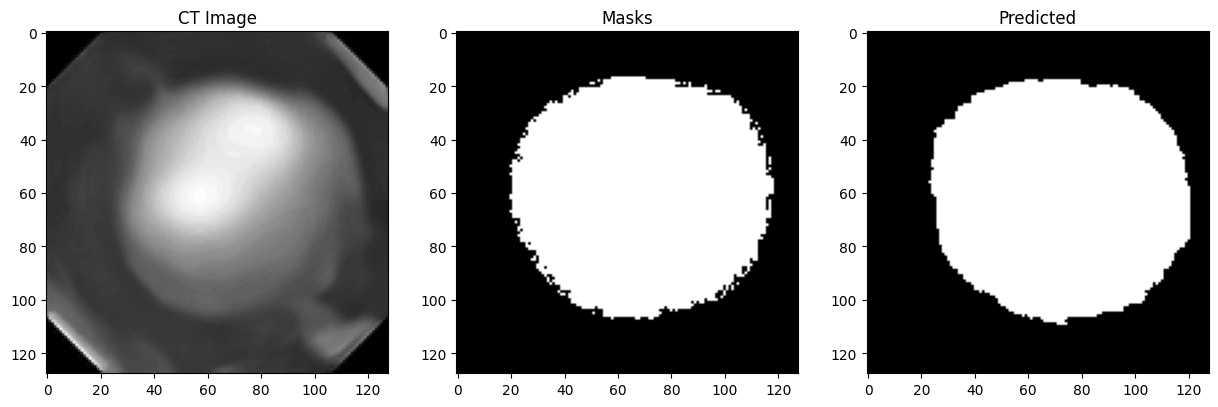

Dice Coef for image 1: 0.9360343255333274


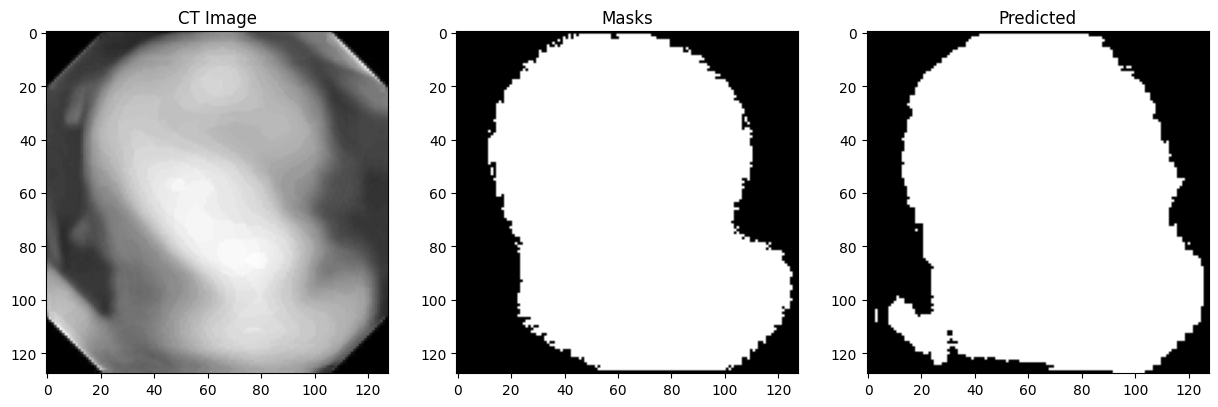

Dice Coef for image 2: 0.9425645812532842


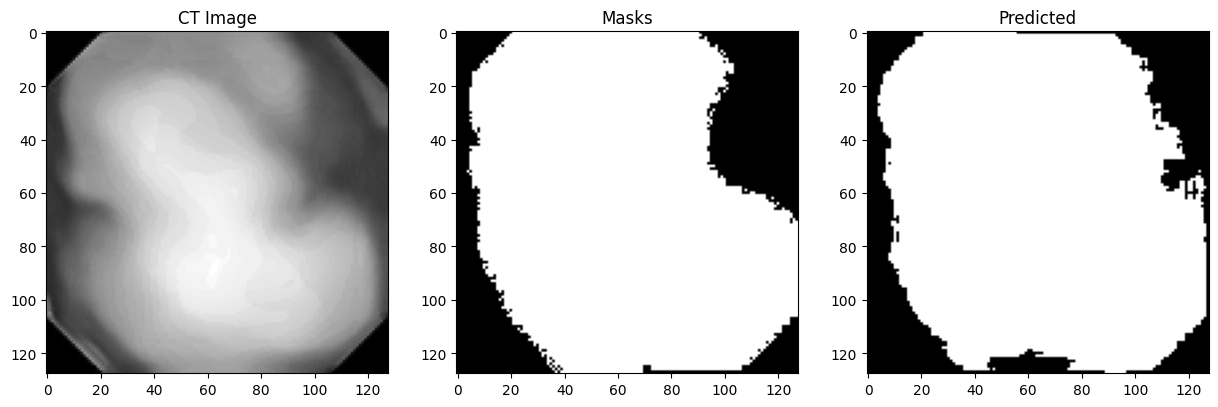

Dice Coef for image 3: 0.9419548278908872


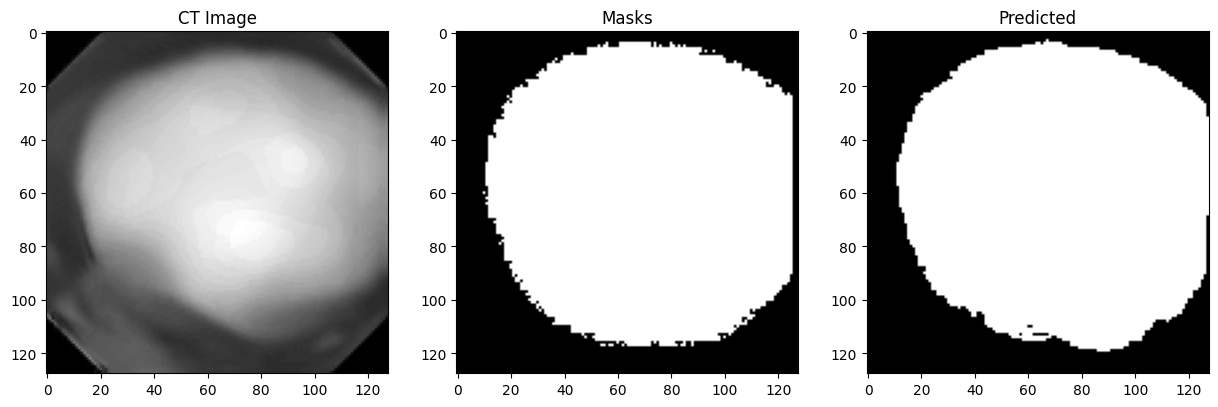

Dice Coef for image 4: 0.943417781919075


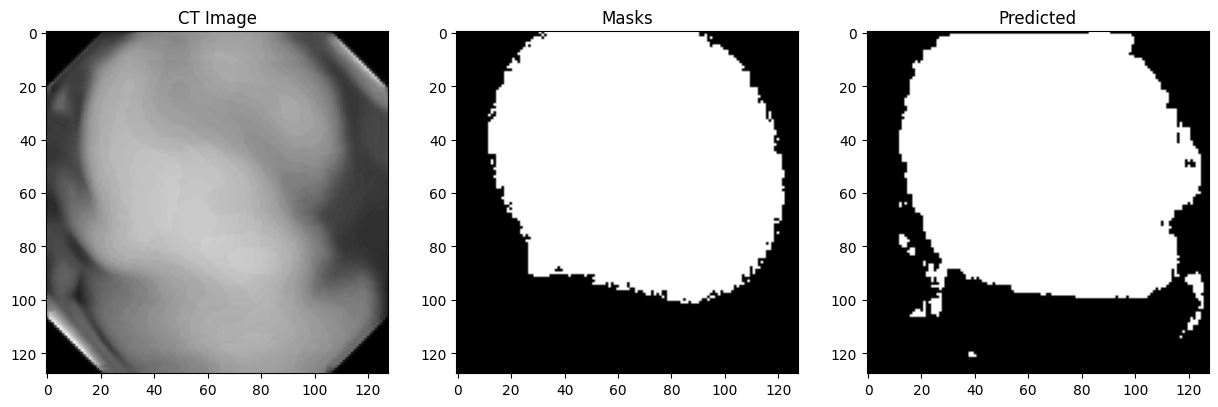

Dice Coef for image 5: 0.8345172308229255


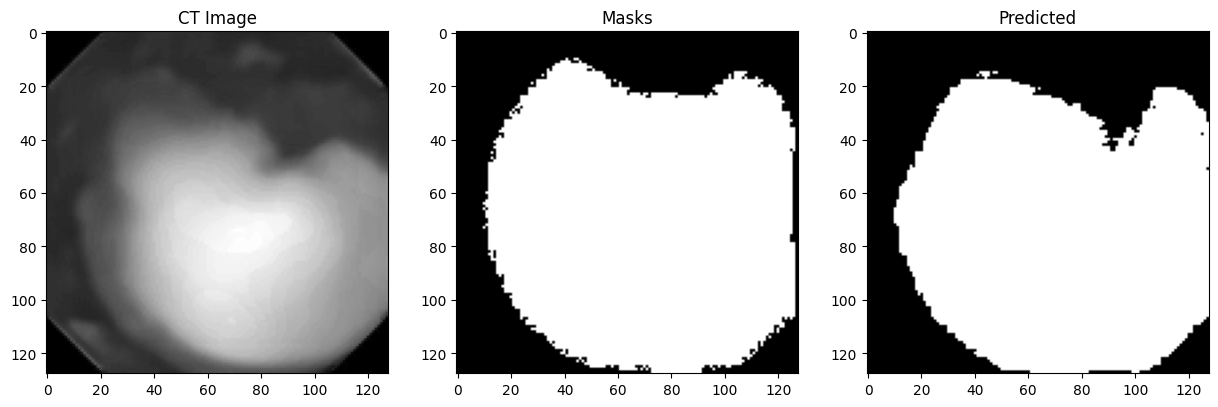

Dice Coef for image 6: 0.8909238601063271


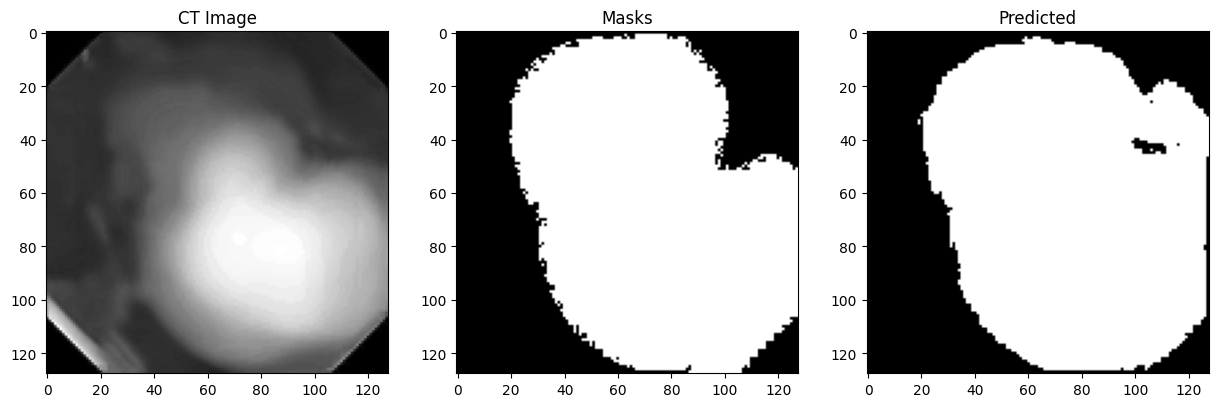

Dice Coef for image 7: 0.9228117434660595


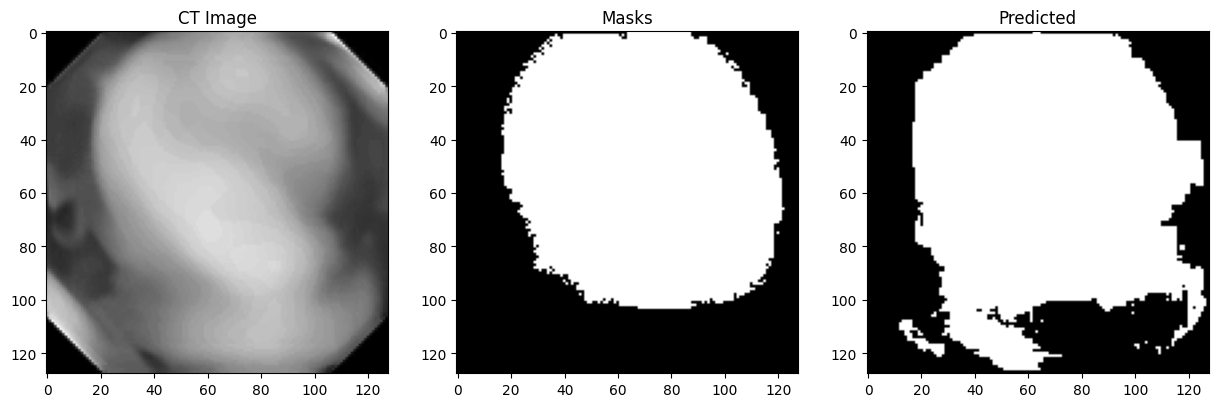

Dice Coef for image 8: 0.7543697856071665


In [19]:
Show_images_CT_Mask_Pred(x_test , y_test , predictions , qual = 8)

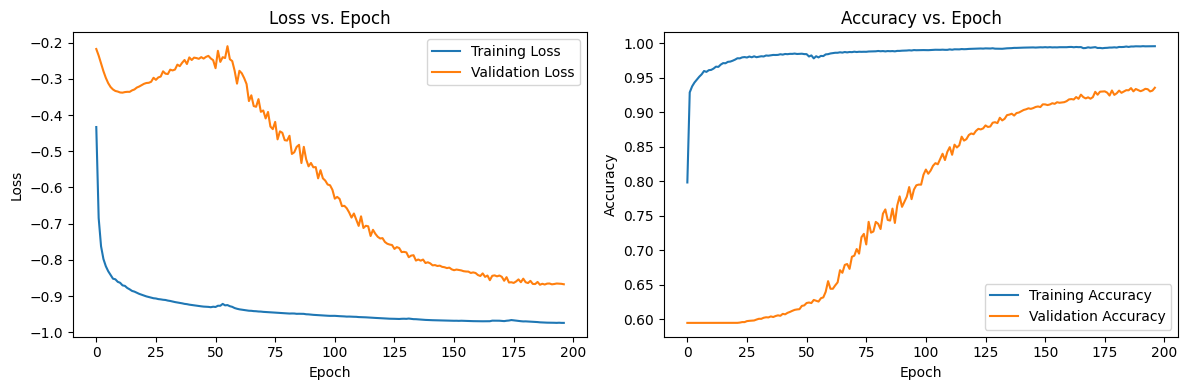

In [20]:
#Plot loss and validation loss :
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#Plot accuracy and validation accuracy :
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
# Sử dụng evaluate để tính toán các metric trên tập test
unet_model.load_weights(checkpoint_filepath)
evaluation = unet_model.evaluate(x=x_test, y=y_test)

# In ra kết quả
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.9361 - loss: -0.8372
Test Loss: -0.837165892124176
Test Accuracy: 0.9361043572425842


In [22]:
# Lưu mô hình tốt nhất
model_savepath = os.path.join(os.getcwd(), 'model.best.keras')
unet_model.save(model_savepath)